In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing


In [8]:
DF = pd.read_csv("Health_insurance.csv")
DF.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [9]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [10]:
DF.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [11]:
DF["sex"]

0       female
1         male
2         male
3         male
4         male
         ...  
1333      male
1334    female
1335    female
1336    female
1337    female
Name: sex, Length: 1338, dtype: object

In [12]:
import plotly.express as px

df = px.data.tips()
fig = px.histogram(DF,
    x="sex",
    color="smoker",
    title= "Number of smokers"
)
fig.show()


In [24]:
le = preprocessing.LabelEncoder()
le.fit(DF.sex)
DF['sex'] = le.transform(DF.sex)
le.fit(DF.smoker)
DF["smoker"] = le.transform(DF.smoker)
#DF = DF.drop("categorical_label",axis=1)
DF.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


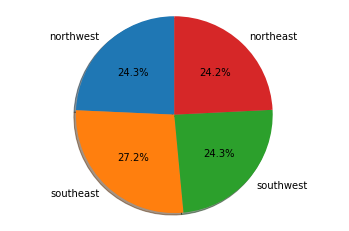

In [36]:
labels = list(set(DF.region))
data = []
for i in range(len(labels)):
    data.append(sum(DF.region==labels[i]))

fig1, ax1 = plt.subplots()
ax1.pie(data, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()